/tmp/ipykernel_119357/3611497973.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return Iq / np.trapz(Iq, q)


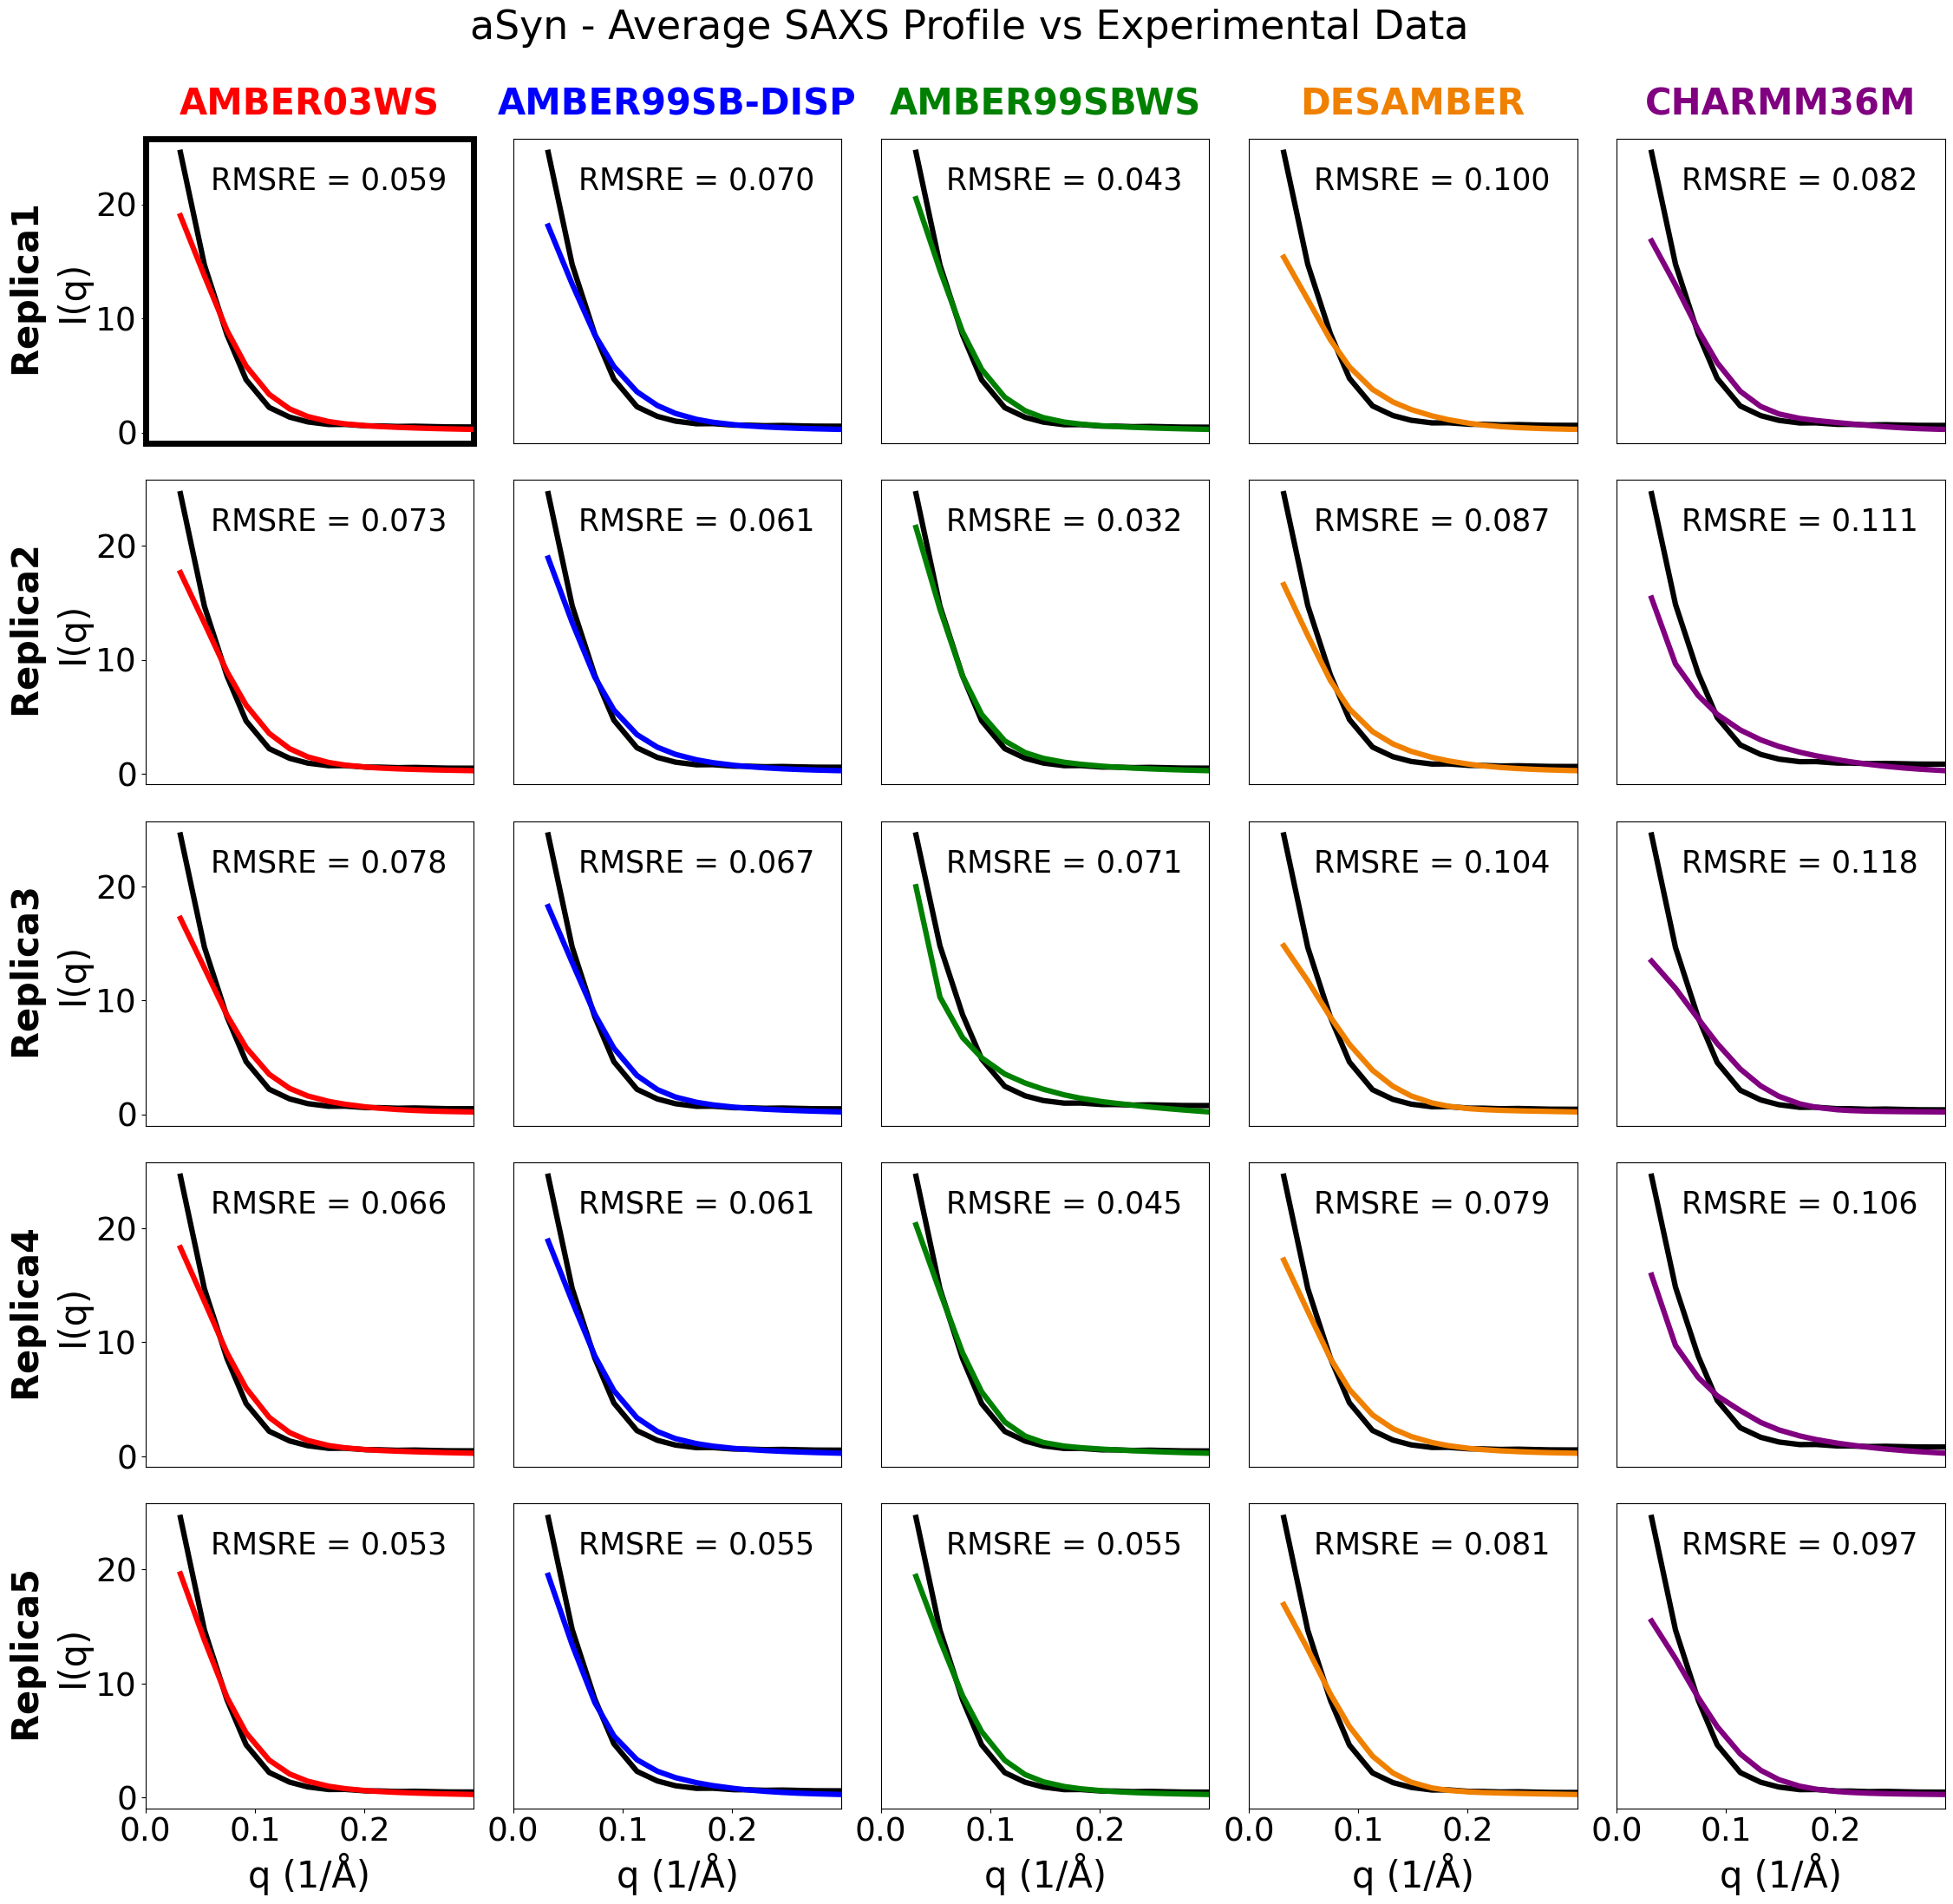

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.patches import Rectangle
from scipy.optimize import minimize
from matplotlib.lines import Line2D

# Function for Chi-Squared Calculation
def chi_squared(params, q_exp, Iq_exp, q_all, Iq_avg):
    scale_factor = params[0]
    off_set = params[1]
    Iq_scaled = Iq_avg * scale_factor + off_set
    Iq_interp = np.interp(q_exp, q_all[0], Iq_scaled)
    residuals = Iq_exp - Iq_interp
    chi2 = np.sum((residuals ** 2) / Iq_exp)
    return chi2

# Function for Area Normalization
def normalize_by_area(q, Iq):
    return Iq / np.trapz(Iq, q)

def get_rrmse_color(rrmse):
    for (lower, upper), color in rrmse_thresholds.items():
        if lower <= rrmse < upper:
            return color
    return 'black'

rrmse_thresholds = {
    (0, 10): 'green',     # Very good fit
    (10, 20): 'blue',    # Good fit
    (20, 30): 'orange',  # Acceptable fit
    (30, np.inf): 'red'    # Poor fit
}

# Input Data
forcefields = ["AMBER03WS", "AMBER99SB-DISP", "AMBER99SBWS", "DESAMBER", "CHARMM36M"]
replicas = ["replica_01", "replica_02", "replica_03", "replica_04", "replica_05"]
row_header = ["Replica 1", "Replica 2", "Replica 3", "Replica 4", "Replica 5"]
color_map = {
    'AMBER03WS': 'red',
    'AMBER99SB-DISP': 'blue',
    'AMBER99SBWS': 'green',
    'CHARMM36M': 'purple',
    'DESAMBER': '#F08000'
}
pdb_folders = "pdb_folders"
exp_file = os.path.join(pdb_folders, "exp.abs")

# Load Experimental Data
exp_data = np.loadtxt(exp_file, skiprows=1)
q_exp = exp_data[:, 0]
Iq_exp = exp_data[:, 1]


# Normalize Experimental Data
Iq_exp = normalize_by_area(q_exp, Iq_exp)

# Set up the plot
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
fig.subplots_adjust(left=0.12, right=0.95, top=0.92, bottom=0.15, wspace=0.12, hspace=0.12)


RMSRE_list = []

for i, rep in enumerate(replicas):
    for j, ff in enumerate(forcefields):
        case = os.path.join(pdb_folders, rep, ff)

        alm_files = glob.glob(os.path.join(case, "frame*abs"))
        if not alm_files:
            continue

        # Load Simulated SAXS Data
        q_all, Iq_all = [], []
        for alm_file in alm_files:
            data = np.loadtxt(alm_file, skiprows=1)
            q = data[:, 0]
            Iq = np.sum(data[:, 1:], axis=1)
            q_all.append(q)
            Iq_all.append(Iq)

        q_all = np.array(q_all)
        Iq_all = np.array(Iq_all)

        # Average Simulated Data and Normalize
        Iq_avg = np.mean(Iq_all, axis=0)
        Iq_avg = normalize_by_area(q_all[0], Iq_avg)


        # Perform Fitting
        initial_guess = [1.0, 0.0]
        bounds = [(0.01, 10), (-10, 10)]  # Allow broad parameter range
        result = minimize(chi_squared, initial_guess, args=(q_exp, Iq_exp, q_all, Iq_avg), bounds=bounds)

        if not result.success:
            print(f"Optimization failed for {case}")
            continue

        best_scale_factor, best_offset = result.x
        Iq_scaled = Iq_avg * best_scale_factor + best_offset
        Iq_interp = np.interp(q_exp, q_all[0], Iq_scaled)

        # Calculate Residuals and RMSRE
        residuals = Iq_interp - Iq_exp
        relative_residuals = residuals / Iq_exp[0]
        rmsre = np.sqrt(np.mean(relative_residuals ** 2))
        rmse = np.sqrt(np.mean(residuals ** 2))

        # Normalize RMSE by the mean of the true experimental values
        mean_Iq_exp = np.mean(Iq_exp)
        rrmse = 100 * (rmse / mean_Iq_exp)
        lab_color = get_rrmse_color(rrmse)

        # Plot Results
        color = color_map.get(ff, "black")
        axs[i, j].plot(q_exp, Iq_exp, lw=4.5, color="black", label="Experimental")
        axs[i, j].plot(q_exp, Iq_interp, lw=4.5, color=color, label="Fitted")

        legend_item = Line2D([0], [0], color="w", linewidth=0, label=f'RMSRE = {rmsre:.3f}')
        axs[i, j].legend(handles=[legend_item], fontsize=18, loc='best', frameon=False)
        axs[i, j].set_xticks([]) 
        axs[i, j].tick_params(axis='y', labelsize=27)
        axs[i, j].set_xlim(0, 0.3)

        #legend_item = Line2D([0], [0], color=lab_color, marker='o', markersize=20, linestyle=' ', linewidth=0, label=f'RRMSE = {rrmse:.0f} % \n RMSRE = {rmsre:.3f}')
        
        # Highlight Specific Case
        if "replica_01/AMBER03WS" in case:
            autoAxis = axs[i, j].axis()
            rec = Rectangle((autoAxis[0], autoAxis[2]),
                            (autoAxis[1] - autoAxis[0]),
                            (autoAxis[3] - autoAxis[2]),
                            fill=False, linewidth=5, edgecolor='black')
            axs[i, j].add_patch(rec)
            rec.set_clip_on(False)
            
        axs[i, j].legend(handles=[legend_item], fontsize=25, loc='best', frameon=False)

        # Append case and RMSRE to the list
        RMSRE_list.append((case, rmsre))

# Print the list after all iterations
RMSRE_list_sorted = sorted(RMSRE_list, key=lambda x: x[1])
#for i in RMSRE_list_sorted:
    #print(i)
    
handles = []
for (lower, upper), color in rrmse_thresholds.items():
    label = f'({lower}-{upper}%)' if upper != np.inf else f'{color} (> {lower}%)'
    
    # Create a legend item using a circle marker with a specified color
    legend_item_marker = Line2D([0], [0], color=color, marker='o', markersize=20, linestyle=' ', label=label)
    handles.append(legend_item_marker)

#fig.legend(handles=handles, ncol=4, fontsize=25, loc='center', bbox_to_anchor=(0.5, 0.1), frameon=False)

# Add Labels and Titles
fig.suptitle('aSyn - Average SAXS Profile vs Experimental Data', fontsize=33)
for ax1, replica in zip(axs[:, 0], row_header):
    ax1.set_ylabel(f'$\\bf{{{replica}}}$\nI(q)', fontsize=30, rotation=90)
for ax2, forcefield in zip(axs[0], forcefields):
    color = color_map.get(forcefield.split("/")[-1], "black")
    ax2.set_title(forcefield, weight='bold', fontsize=30, pad=20, color=color)
for ax3 in axs[-1]:
    ax3.set_xlabel('q (1/Å)', fontsize=30)
    ax3.set_xticks([0, 0.1, 0.2])
    ax3.tick_params(axis='x', labelsize=27)
for row in axs:
    for a in row[1:]:
        a.set_yticks([])